In [5]:
import numpy as np 
import pandas as pd
from pylab import mpl, plt

# Backtesting Base Class

In [6]:
class BacktestBase(object):

    # Sets self.verbose to True to get full output.\ 
    # Set initial number of `trade` to 0
    # ftc: fixed transaction cost per trade
    # ptc: proportional transaction cost per trade
    # unit of instrument
    def __init__(self, symbol, start, end, amount, ftc=0.0, ptc=0.0, verbose=True):
        self.symbol = symbol
        self.start = start
        self.end = end
        self.initial_amount = amount  
        self.amount = amount  
        self.ftc = ftc  
        self.ptc = ptc  
        self.units = 0  
        self.position = 0  
        self.trades = 0  
        self.verbose = verbose  
        self.get_data()
    
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv('http://hilpisch.com/pyalgo_eikon_eod_data.csv',
                          index_col=0, parse_dates=True).dropna()
        raw = pd.DataFrame(raw[self.symbol])
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: 'price'}, inplace=True)
        raw['return'] = np.log(raw / raw.shift(1))
        self.data = raw.dropna()
    
    # Plot data
    def plot_data(self, cols=None):
        ''' Plots the closing prices for symbol.
        '''
        if cols is None:
            cols = ['price']
        self.data['price'].plot(figsize=(10, 6), title=self.symbol)
    
    # Bar aka an event
    def get_date_price(self, bar):
        ''' Return date and price for bar.
        '''
        date = str(self.data.index[bar])[:10]
        price = self.data.price.iloc[bar]
        return date, price
    
    def print_balance(self, bar):
        ''' Print out current cash balance
        '''
        date, price = self.get_date_price(bar)
        print(f'{date} | current balance {self.amount:.2f}')
    
    def print_net_wealth(self, bar):
        ''' Print out current cash balance info.
        '''
        date, price = self.get_date_price(bar)
        net_wealth = self.units * price + self.amount
        print(f'{date} | current net wealth {net_wealth:.2f}')
    
    
    def place_buy_order(self, bar, units=None, amount=None):
        ''' Place a buy order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount/price)
        self.amount -= (units * price) * (1 + self.ptc) + self.ftc
        self.unit += units 
        self.trade += 1 
        if self.verbose:
            print(f'{date} | buying {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)
    
    def place_sell_order(self, bar, units=None, amount=None):
        ''' Place a sell order.
        '''
        date, price = self.get_date_price(bar)
        if units is None:
            units = int(amount / price)
        self.amount += (units * price) * (1 - self.ptc) - self.ftc  
        self.units -= units  
        self.trades += 1
        if self.verbose:
            print(f'{date} | selling {units} units at {price:.2f}')
            self.print_balance(bar)
            self.print_net_wealth(bar)

    def close_out(self, bar):
        ''' Closing out a long or short position.
        '''
        date, price = self.get_date_price(bar)
        self.amount += self.units * price  
        self.units = 0
        self.trades += 1
        if self.verbose:
            print(f'{date} | inventory {self.units} units at {price:.2f}')
            print('=' * 55)
        print(f'Final balance   [{self.amount:.2f}]')  
        perf = ((self.amount - self.initial_amount) /
                self.initial_amount * 100)
        print(f'Net Performance [{perf:.2f}]')  
        print(f'Trades Executed [{self.trades:.2f}]')  
        print('=' * 55)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2515 entries, 2010-01-05 to 2019-12-31
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   2515 non-null   float64
 1   return  2515 non-null   float64
dtypes: float64(2)
memory usage: 58.9 KB
None
             price    return
Date                        
2019-12-24  284.27  0.000950
2019-12-26  289.91  0.019646
2019-12-27  289.80 -0.000380
2019-12-30  291.52  0.005918
2019-12-31  293.65  0.007280


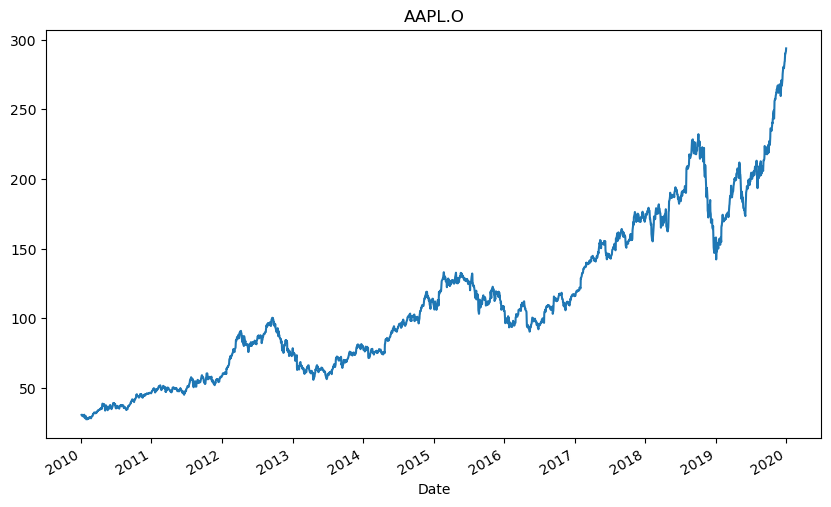

In [7]:
if __name__ == '__main__':
    bb = BacktestBase('AAPL.O', '2010-1-1', '2019-12-31', 10000)
    print(bb.data.info())
    print(bb.data.tail())
    bb.plot_data()

# Long Backtesting